In [1]:
import numpy as np
import torch
from scipy.special import softmax
import matplotlib.pyplot as plt

In [3]:
class DualOptimizer():
    def __init__(self,
                 ref_log_probs_sum,
                 helpfulness_log_probs_sum,
                 safety_log_probs_sum,
                 kl_coeff,
                 margins, # E_{pi}[safety] - E_{pi_ref}[safety]>= margins
                 **kwargs):
        self.helpfulness_scores = helpfulness_log_probs_sum - ref_log_probs_sum
        self.safety_scores = safety_log_probs_sum - ref_log_probs_sum
        self.margins = margins
        self.kl_coeff = kl_coeff
        self.kl_divs = np.mean(ref_log_probs_sum-safety_log_probs_sum)
        self.kwargs = kwargs
    
    def log_mean_Z_values(self, logits):
        return np.log(np.mean(np.exp(logits-logits.max(axis=1).reshape(-1, 1)), axis=1))+logits.max(axis=1)
    
    def solve(self, optimizer='GD', set_optimum=False, verbose=False, **kwargs):
        lam_init = 1 if 'lam_init' not in kwargs.keys() else kwargs['lam_init']
        lr = 1 if 'lr' not in kwargs.keys() else 2*kwargs['lr']
        max_iters = 200 if 'num_iters' not in kwargs.keys() else kwargs['num_iters']
        if optimizer == 'GD':
            is_converge = False
            num_loops = 0
            while not is_converge:
                lam = lam_init
                lr = lr/2**num_loops # learning rate decay
                lam_trajectory = [lam_init]
                for idx_iter in range(max_iters):
                    logits = (self.helpfulness_scores + self.safety_scores * lam)
                    sm_probs = softmax(logits, axis=1)
                    gradient = np.sum(sm_probs * self.safety_scores, axis=1).mean() + self.kl_divs-self.margins/self.kl_coeff
                    lam = np.maximum(lam - lr*gradient, 0)
                    lam_trajectory.append(lam)
                    if idx_iter >= 10 and np.abs(lam-np.array(lam_trajectory[-1:-6:-1])).max()<1e-5: # the maximal difference, compared to the last 5 iterations, are smaller than 1e-5
                        is_converge = True
                        if verbose:
                            print(f'The optimization converges to a finite maximizer!')
                        break
                if is_converge:
                    if set_optimum:
                        self.lam_star = lam
                    break
                num_loops += 1
                if num_loops >= 5: # fail the optimization after 5 loops
                    print(f'The dual problem (margins={self.margins}, sample_shape={self.helpfulness_scores.shape}) may not have a finite maximizer!')
                    if set_optimum:
                        self.lam_star = None
                    break
            return lam_trajectory if is_converge else None

In [4]:
log_probs = torch.load('/home/xinmeng/safe-rlhf/output/generate/alpaca-7b-reproduced_log_probs_3epoch_new.pt').cpu().numpy()
full_ref_log_probs_sum = np.sum(log_probs[:, :, 512:1024]*(log_probs[:, :, 512:1024] != 10), axis = -1)
full_helpfulness_log_probs_sum = np.sum(log_probs[:, :, 1536:]*(log_probs[:, :, 1536:] != 10), axis = -1)
full_safety_log_probs_sum = np.sum(log_probs[:, :, 1024:1536]*(log_probs[:, :, 1024:1536] != 10), axis = -1)

## 1. A demo case with constraint $\mathbb{E}_{\pi}[{\rm safety}]-\mathbb{E}_{\pi_{\rm ref}}[{\rm safety}]\geq {\rm margin}=0.5$

In [9]:
do = DualOptimizer(full_ref_log_probs_sum, full_helpfulness_log_probs_sum, full_safety_log_probs_sum, kl_coeff=0.1, margins=0.5)
lam_trajectory = do.solve(lr=2, max_iters=100, set_optimum=True)

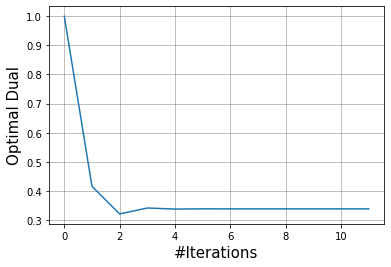

In [10]:
plt.plot(lam_trajectory)
plt.xlabel('#Iterations', fontsize=15)
plt.ylabel('Optimal Dual', fontsize=15)

plt.grid(True)
plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5)

## 2. Dual lanscape with respect to the (margin, #prompts)

In [12]:
margin_grid = np.linspace(0.2, 1.5, 20)
num_prompt_grid = list(np.arange(100, 2000, 100))

lam_mp_list = np.full((len(margin_grid), len(num_prompt_grid)), None, dtype=object)
for idx_mg, margin in enumerate(margin_grid):
    for idx_num, num_prompt in enumerate(num_prompt_grid):
        do = DualOptimizer(full_ref_log_probs_sum[:num_prompt], full_helpfulness_log_probs_sum[:num_prompt], full_safety_log_probs_sum[:num_prompt], kl_coeff=0.1, margins=margin)
        do.solve(lr=2, max_iters=200, set_optimum=True)
        lam_mp_list[idx_mg][idx_num] = do.lam_star

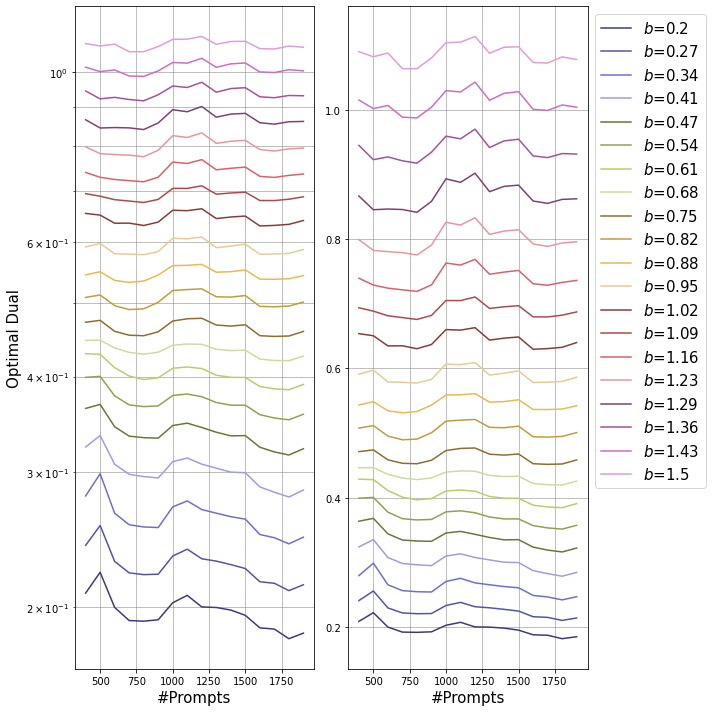

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # Adjust the size as needed
axs = axs.flatten()

cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in range(20)]
for idx_mg, margin in enumerate(margin_grid):
    if not np.all(lam_mp_list[idx_mg]==None):
        modified_lam_mp_list = [lam for lam in lam_mp_list[idx_mg]]
        for idx_lam, lam in enumerate(modified_lam_mp_list):
            if lam != None:
                modified_lam_mp_list[idx_lam] = np.maximum(lam, 1e-8)
        axs[0].semilogy(num_prompt_grid[3:], modified_lam_mp_list[3:], label=f'$b$={round(margin, 2)}', color=colors[idx_mg])
        axs[1].plot(num_prompt_grid[3:], modified_lam_mp_list[3:], label=f'$b$={round(margin, 2)}', color=colors[idx_mg])

for i in range(2):
    axs[i].set_xlabel('#Prompts', fontsize=15)
    axs[i].grid(True)
    axs[i].grid(which='both', color='gray', linestyle='-', linewidth=0.5)
axs[0].set_ylabel('Optimal Dual', fontsize=15)
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)


plt.subplots_adjust(top=0.95)
plt.tight_layout()
plt.show()


## 3. Dual lanscape with respect to the (margin, #responses)

In [15]:
margin_grid = np.linspace(0.2, 1.5, 20)
num_response_grid = np.arange(8, 97, 8)

lam_mr_list = np.full((len(margin_grid), len(num_response_grid)), None, dtype=object)
for idx_mg, margin in enumerate(margin_grid):
    for idx_num, num_response in enumerate(num_response_grid):
        do = DualOptimizer(full_ref_log_probs_sum[:,:num_response], full_helpfulness_log_probs_sum[:,:num_response], full_safety_log_probs_sum[:,:num_response], kl_coeff=0.1, margins=margin)
        do.solve(lr=2, max_iters=200, set_optimum=True)
        lam_mr_list[idx_mg][idx_num] = do.lam_star

The dual problem (margins=1.5, sample_shape=(2004, 8)) may not have a finite maximizer!


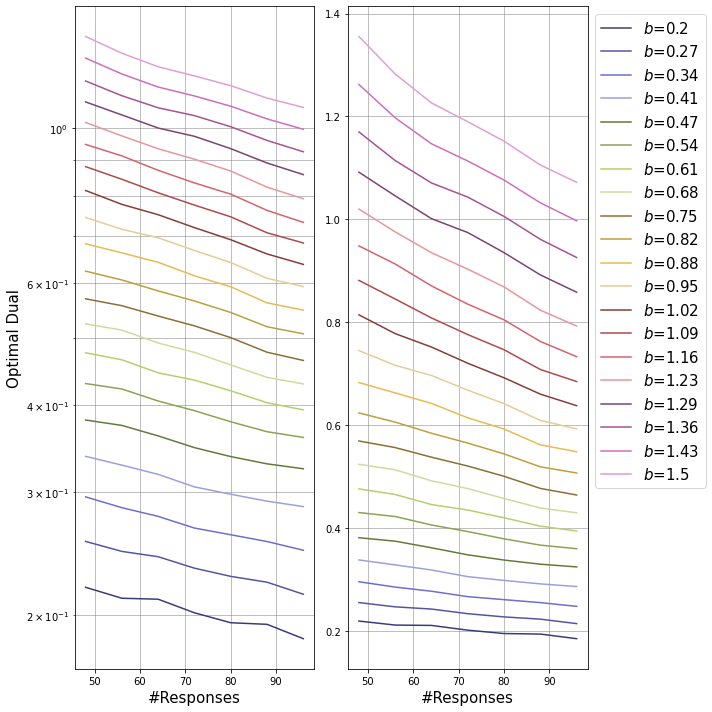

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # Adjust the size as needed
axs = axs.flatten()

cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in range(20)]
for idx_mg, margin in enumerate(margin_grid):
    if not np.all(lam_mp_list[idx_mg]==None):
        modified_lam_mr_list = [lam for lam in lam_mr_list[idx_mg]]
        for idx_lam, lam in enumerate(modified_lam_mr_list):
            if lam != None:
                modified_lam_mr_list[idx_lam] = np.maximum(lam, 1e-8)
        axs[0].semilogy(num_response_grid[5:], modified_lam_mr_list[5:], label=f'$b$={round(margin, 2)}', color=colors[idx_mg])
        axs[1].plot(num_response_grid[5:], modified_lam_mr_list[5:], label=f'$b$={round(margin, 2)}', color=colors[idx_mg])

for i in range(2):
    axs[i].set_xlabel('#Responses', fontsize=15)
    axs[i].grid(True)
    axs[i].grid(which='both', color='gray', linestyle='-', linewidth=0.5)
axs[0].set_ylabel('Optimal Dual', fontsize=15)
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)


plt.subplots_adjust(top=0.95)
plt.tight_layout()
plt.show()